In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import env


## Iris Dataset

In [3]:
#acquire data
sql= '''
SELECT * FROM measurements JOIN species USING(species_id);
'''
df = pd.read_sql(sql,env.get_db_url('iris_db'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   species_id      150 non-null    int64  
 1   measurement_id  150 non-null    int64  
 2   sepal_length    150 non-null    float64
 3   sepal_width     150 non-null    float64
 4   petal_length    150 non-null    float64
 5   petal_width     150 non-null    float64
 6   species_name    150 non-null    object 
dtypes: float64(4), int64(2), object(1)
memory usage: 8.3+ KB


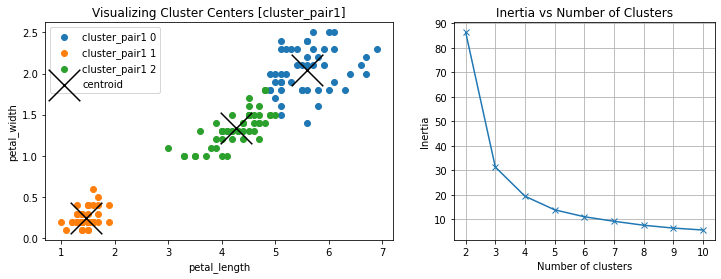

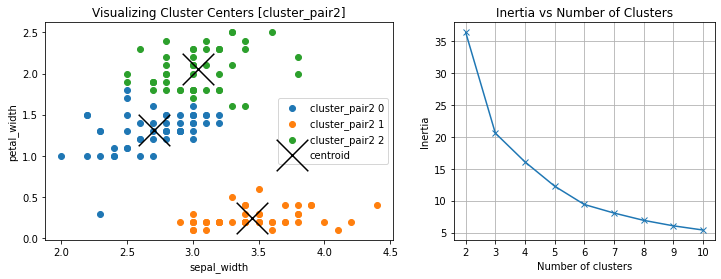

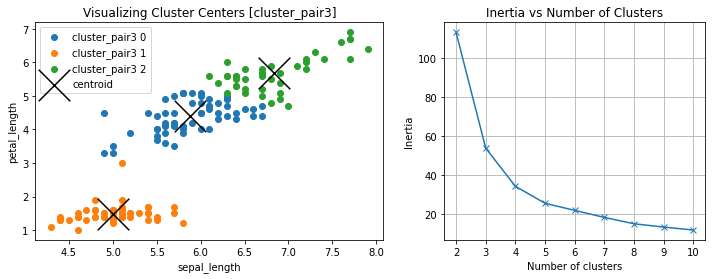

In [5]:
#different features I want to use for each kmeans model
pairs = [['petal_length','petal_width'],['sepal_width','petal_width'],['sepal_length','petal_length']]

for cnt, p in enumerate(pairs):
    #create X subset
    X = df[p]
    #create and fit model
    model = KMeans(n_clusters=3).fit(X)
    
    #cluster name
    cl_name = 'cluster_pair' + str(cnt+1)
    #get clusters
    df[cl_name] = model.predict(X)
    
    #get centroids
    centroids = pd.DataFrame(model.cluster_centers_, columns=X.columns)
    #PLOTTING    
#     plt.figure(figsize=(14,8))
    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1.5]}, figsize=(12,4))
    #PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
    plt.subplot(121)
    #Loop over the rows, grouped by cluster - plot each cluster
    for grp, subset in df.groupby(cl_name):
        #x is first in pair, y is second
        plt.scatter(subset[p[0]],subset[p[1]], label=cl_name + ' ' + str(grp))
    #throw on centroids
    centroids.plot.scatter(x=p[0],y=p[1],c='black',marker='x',s=1000,ax=plt.gca(),label='centroid')
    #pretty up the graph
    plt.legend()
    plt.xlabel(p[0])
    plt.ylabel(p[1])
    plt.title(f'Visualizing Cluster Centers [{cl_name}]')
    
    #PLOT THE INTERIA CHANGES
    plt.subplot(122)
    with plt.style.context('seaborn-whitegrid'):
        #generate model, fit, get inertia for multiple values for num_clusters
        pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 11)}).plot(marker='x')
        plt.xticks(range(2, 11))
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Inertia vs Number of Clusters')

## Mall Dataset

In [6]:
#ACQUIRE
sql = """
SELECT * FROM customers;
"""
#get data
df = pd.read_sql(sql,env.get_db_url('mall_customers'))
#general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
#PREP MODEL INPUTS
#Use all rows but gender
X = df.iloc[:,2:]
#create a scaled version
X_sc = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns)

In [8]:
X.columns

Index(['age', 'annual_income', 'spending_score'], dtype='object')

In [9]:
type(X_sc)

pandas.core.frame.DataFrame

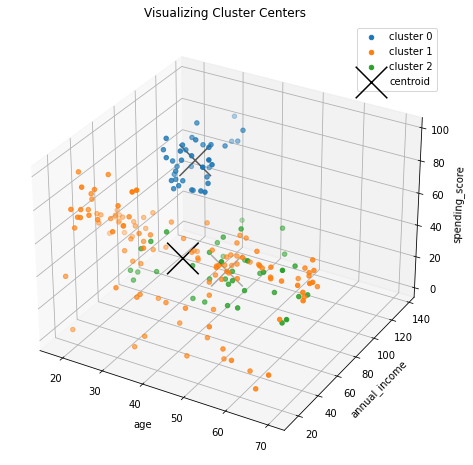

In [10]:
#MODEL and graph
model = KMeans(n_clusters=3).fit(X)


#get clusters
df['cluster'] = model.predict(X)

#get centroids
centroids = pd.DataFrame(model.cluster_centers_, columns=X.columns)
#PLOTTING    
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(projection='3d')

#PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in df.groupby('cluster'):
    #x is first in pair, y is second
    ax.scatter(subset['age'],subset['annual_income'],subset['spending_score'],
               label='cluster ' + str(grp))
#throw on centroids
ax.scatter(xs=centroids['age'],ys=centroids['annual_income'],zs=centroids['spending_score'],
           c='black',marker='x',s=1000,label='centroid')
#pretty up the graph
ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('annual_income')
ax.set_zlabel('spending_score')
ax.set_title(f'Visualizing Cluster Centers');


##### Same plot, but make it interactive and choose best viewing angle

<IPython.core.display.Javascript object>


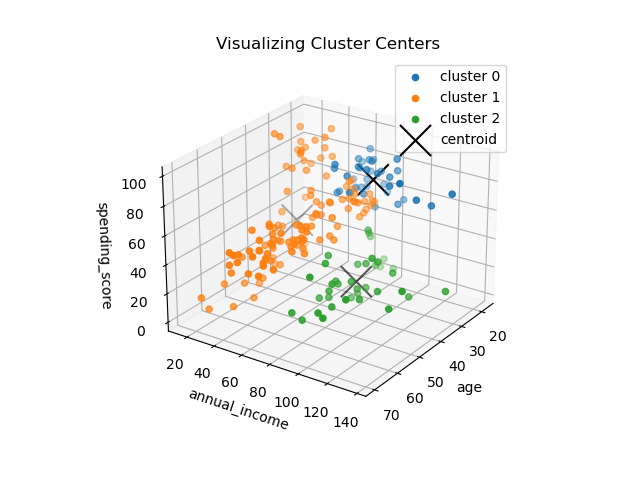

In [15]:
%matplotlib notebook

#PLOTTING    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in df.groupby('cluster'):
    #x is first in pair, y is second
    ax.scatter(subset['age'],subset['annual_income'],subset['spending_score'],
               label='cluster ' + str(grp))
#throw on centroids
ax.scatter(xs=centroids['age'],ys=centroids['annual_income'],zs=centroids['spending_score'],
           c='black',marker='x',s=500,label='centroid')
#pretty up the graph
ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('annual_income')
ax.set_zlabel('spending_score')
ax.set_title(f'Visualizing Cluster Centers');
#good viewing angle
ax.view_init(10, 30)


##### Now use scaled data

In [12]:
#MODEL and graph
model = KMeans(n_clusters=3).fit(X_sc)

#get clusters
X_sc['cluster_scaled'] = model.predict(X_sc)

#get centroids
centroids_sc = pd.DataFrame(model.cluster_centers_, columns=X_sc.columns[0:3])

In [13]:
centroids_sc

,age,annual_income,spending_score
0,0.695913,0.265241,0.403699
1,0.201105,0.370858,0.708641
2,0.398810,0.544106,0.189504


<IPython.core.display.Javascript object>


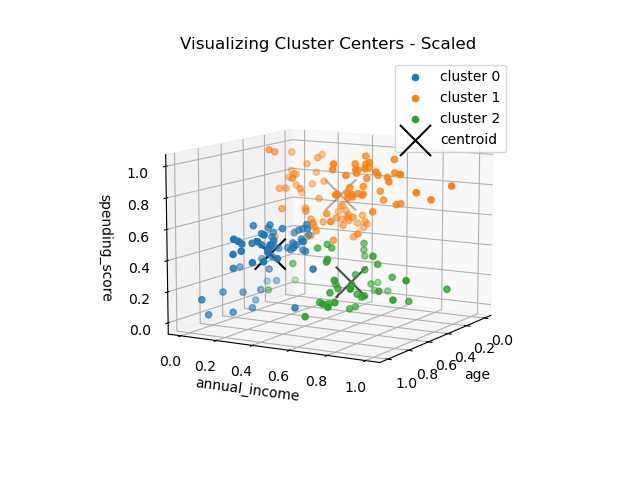

In [14]:
%matplotlib notebook

#PLOTTING    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in X_sc.groupby('cluster_scaled'):
    #x is first in pair, y is second
    ax.scatter(subset['age'],subset['annual_income'],subset['spending_score'],
               label='cluster ' + str(grp))

#throw on centroids
ax.scatter(xs=centroids_sc['age'],ys=centroids_sc['annual_income'],zs=centroids_sc['spending_score'],
           c='black',marker='x',s=500,label='centroid')
#pretty up the graph
ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('annual_income')
ax.set_zlabel('spending_score')
ax.set_title(f'Visualizing Cluster Centers - Scaled');
#good viewing angle
ax.view_init(10, 30)

##### Look at which  points changed allegiances

The following code is a bit confusing, but essentially I mapped cluster scaled to the cluster values of the unscaled.  This was done by visually looking at the centroids and choosing the appropriate value.  Then I compared the two columns and if the scaled and unscaled cluster didn't match, I labelled them as a new cluster.  This just helps us visualize which points changed clusters b/w the scaled and unscaled datasets.

In [25]:
df['cluster_scaled'] = X_sc['cluster_scaled'].copy()
#Re label these so that the order of clusters match the original plot
conditions = [
    df['cluster_scaled']==0,
    df['cluster_scaled']==1,
    df['cluster_scaled']==2
]
df['cluster_scaled_map'] = np.select(conditions,[1,0,2])
df['diff_cluster']= df['cluster'] == df['cluster_scaled_map']
df.head()

,customer_id,gender,age,annual_income,spending_score,cluster,cluster_scaled,diff_cluster,cluster_scaled_map
0,1,Male,19,15,39,1,1,False,0
1,2,Male,21,15,81,1,1,False,0
2,3,Female,20,16,6,1,2,False,2
3,4,Female,23,16,77,1,1,False,0
4,5,Female,31,17,40,1,1,False,0


In [30]:
df['diff_cluster'] = np.select([df['cluster'] != df['cluster_scaled_map']],[4],default=df['cluster'])

In [31]:
df.diff_cluster.value_counts()

4    63
1    62
0    39
2    36
Name: diff_cluster, dtype: int64

<IPython.core.display.Javascript object>


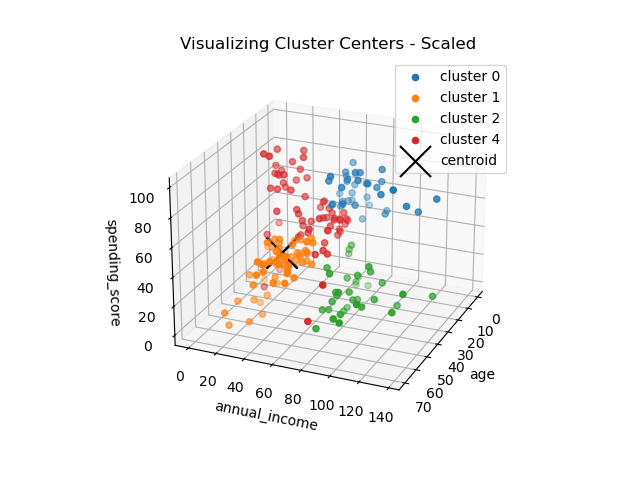

In [33]:
#PLOTTING    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in df.groupby('diff_cluster'):
    #x is first in pair, y is second
    ax.scatter(subset['age'],subset['annual_income'],subset['spending_score'],
               label='cluster ' + str(grp))

#throw on centroids
ax.scatter(xs=centroids_sc['age'],ys=centroids_sc['annual_income'],zs=centroids_sc['spending_score'],
           c='black',marker='x',s=500,label='centroid')
#pretty up the graph
ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('annual_income')
ax.set_zlabel('spending_score')
ax.set_title(f'Visualizing Cluster Centers - Scaled');
#good viewing angle
ax.view_init(10, 30)